<a href="https://colab.research.google.com/github/abshilpa/LLM---Sentiment-Analysis/blob/main/Final_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT-based Sentiment Analysis for Amazon Reviews

This script implements a complete pipeline for fine-tuning a BERT model for
sentiment analysis on Amazon product reviews. The model classifies reviews
into three categories: Negative, Neutral, and Positive.

Author: Shilpa
Course: MSC Project

Key Features:
Data preprocessing and exploratory data analysis
BERT tokenization and dataset preparation
Model fine-tuning with evaluation metrics
Comprehensive visualization of results
Custom prediction functionality

Dataset: Amazon Reviews CSV file containing 'reviewText' and 'overall' rating columns
Model: BERT-base-uncased from Kaggle

Data set Link: https://www.kaggle.com/code/tarkkaanko/amazon-review-sentiment-analysis/input


## IMPORTS AND ENVIRONMENT SETUP

In [9]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import re
from textblob import TextBlob

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, random_split

torch.manual_seed(36)
np.random.seed(36)


## DATA LOADING AND EXPLORATION

In [10]:
def loading_Amazonreviewdata(file_path):
    """
    Loadding Amazon reviews dataset and performing data exploration.

     Drops rows with missing review text
     Returns cleaned DataFrame

    """
    print(" Loading Amazon review Raw dataset from Github ")

    # Loading the CSV file - Amazon review Raw dataset from Github
    Amazonreview = pd.read_csv(file_path)
    print(f"raw dataset: {Amazonreview.head()}")
    print(f"raw dataset: {Amazonreview.info()}")
    print(f"dataset shape: {Amazonreview.shape}")
    print(f"Columns: {list(Amazonreview.columns)}")

    # Removing rows with missing review text
    initial_size = len(Amazonreview)
    Amazonreview = Amazonreview.dropna(subset=['reviewText'])

    print(f" Removed {initial_size - len(Amazonreview)} rows with missing reviewText")
    print(f"Final dataset shape: {Amazonreview.shape}")

    # Displaying basic statistics about the ratings
    print("\n Rating distribution:")
    print(Amazonreview['overall'].value_counts().sort_index())

    return Amazonreview

# Loading the dataset from github
Amazonreview = loading_Amazonreviewdata("https://raw.githubusercontent.com/abshilpa/LLM---Sentiment-Analysis/refs/heads/main/amazon_reviews.csv")


 Loading Amazon review Raw dataset from Github 
raw dataset:    Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2           1K3      4.0   
3           3           1m2      5.0   
4           4  2&amp;1/2Men      5.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   
3  This think has worked out great.Had a diff. br...  2013-11-21       382   
4  Bought it with Retail Packaging, arrived legit...  2013-07-13       513   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0           0           0                   0   
1            0           0           0                   0   
2            0           0           0     

## SENTIMENT MAPPING AND LABEL CREATION

In [11]:
# Mapping Sentiment and Creating Lables

def map_sentiment(rating):
    """
    Convert numerical ratings to sentiment categories.

     1-2 stars: Clearly negative sentiment
     3 stars: Neutral/mixed sentiment (middle ground)
     4-5 stars: Positive sentiment

    This mapping balances the Amazon review dataset while maintaining meaningful distinctions
    between sentiment categories as positive, negative and netural.
    """
    if rating in [1.0, 2.0]:
        return 0  # Negative sentiment
    elif rating == 3.0:
        return 1  # Neutral sentiment
    else:  # 4.0 and 5.0
        return 2  # Positive sentiment

# Applying sentiment mapping
print("Creating sentiment labels")
Amazonreview['sentiment'] = Amazonreview['overall'].apply(map_sentiment)

# Creating human-readable labels for visualization
Amazonreview['sentiment_label'] = Amazonreview['sentiment'].replace({
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive'
})

print(" Sentiment mapping completed")
print(f" Sentiment distribution:")
print(Amazonreview['sentiment_label'].value_counts())


Creating sentiment labels
 Sentiment mapping completed
 Sentiment distribution:
sentiment_label
Positive    4448
Negative     324
Neutral      142
Name: count, dtype: int64


## TEXT PREPROCESSING

In [12]:
# Cleaning  and preprocessing review text for BERT model as input

def clean_text(text):
    """
    Cleaning and preprocessing review text for BERT input.

    Lowercase and remove non-letter characters
    Keeps spaces for word separation

    """
    # Converting to string in case of non-string inputs
    text = str(text)


    # removing punctuation, numbers, and special characters
    cleaned = re.sub("[^a-zA-Z]", " ", text)

    # Converting to lowercase and removing extra whitespace
    cleaned = cleaned.lower().strip()

    # Replacing multiple spaces with single space
    cleaned = re.sub(r'\s+', ' ', cleaned)

    return cleaned

print("Cleaning review text")

# Applying text cleaning to create a clean version
Amazonreview['reviewText_clean'] = Amazonreview['reviewText'].apply(clean_text)

# Showing example of text cleaning
print("\n Text cleaning example:")
print(f"Original: {Amazonreview['reviewText'].iloc[0][:100]}")
print(f"Cleaned:  {Amazonreview['reviewText_clean'].iloc[0][:100]}")

print("Text preprocessing completed")


Cleaning review text

 Text cleaning example:
Original: No issues.
Cleaned:  no issues
Text preprocessing completed


 ## EXPLORATORY DATA ANALYSIS WITH VISUALIZATION

Analyzing review lengths
 Review length statistics:
   Mean: 51.0 words
   Median: 33.0 words
   Max: 1553 words
   95th percentile: 137.0 words


/tmp/ipython-input-36-1923426734.py:104: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




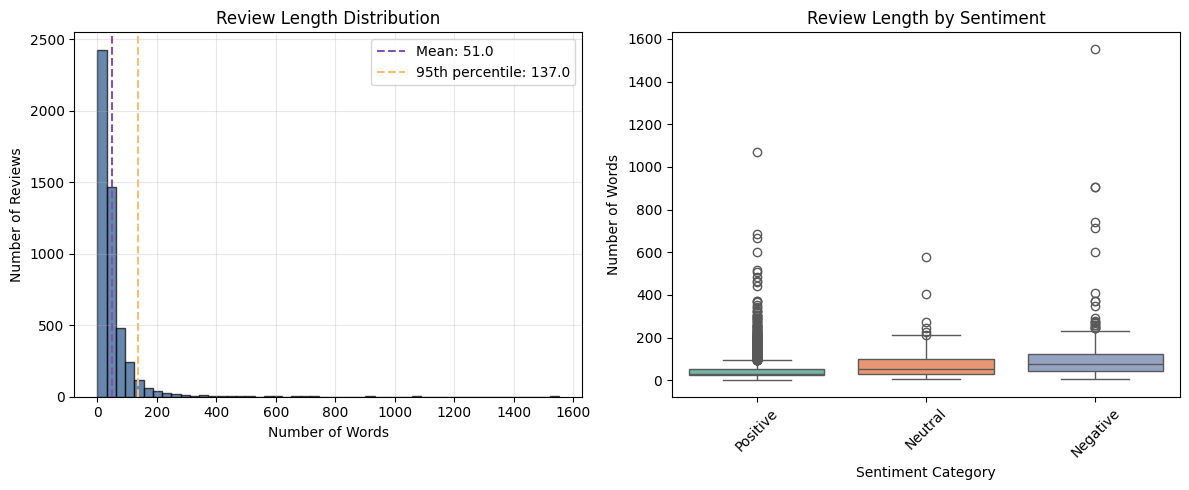

In [36]:
# Creating comprehensive visualization for categorical variables

def categorical_variable_summary(Amazonreview, column_name, title=None):
    """
      Visualizing a categorical column with bar and pie charts.

      Shows counts and percentages
      Uses clean, interactive Plotly visuals

    """
    if title is None:
        title = f"Distribution of {column_name}"

    # Define professional color scheme
    colors = ['#074799', '#27548A', '#7F55B1', '#F2C078', '#DA6C6C']

    # Create subplot with bar chart and pie chart
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Count Distribution", "Percentage Distribution"),
        specs=[[{"type": "xy"}, {"type": "domain"}]]
    )

    # Get value counts for the column
    value_counts = Amazonreview[column_name].value_counts()

    # Add bar chart
    fig.add_trace(
        go.Bar(
            y=value_counts.values.tolist(),
            x=[str(i) for i in value_counts.index],
            text=value_counts.values.tolist(),
            textfont=dict(size=15),
            textposition='auto',
            marker=dict(color=colors[:len(value_counts)],
                       line=dict(color='#DF6D2D', width=1)),
            name="Counts"
        ),
        row=1, col=1
    )

    # Add pie chart
    fig.add_trace(
        go.Pie(
            labels=value_counts.keys(),
            values=value_counts.values,
            textfont=dict(size=12),
            textposition='auto',
            marker=dict(colors=colors[:len(value_counts)]),
            name="Percentages"
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title={'text': title, 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
        template='plotly_white',
        height=400,
        showlegend=False
    )

    fig.show()

def analyze_review_lengths(Amazonreview):
    """
    Analyzing and visualizing review length patterns.

    Helps choose max_length for BERT
    Detects outliers and patterns

    """
    print("Analyzing review lengths")

    # Calculate review lengths in words
    Amazonreview['review_length'] = Amazonreview['reviewText_clean'].apply(lambda x: len(x.split()))

    # Displaying statistics
    print(f" Review length statistics:")
    print(f"   Mean: {Amazonreview['review_length'].mean():.1f} words")
    print(f"   Median: {Amazonreview['review_length'].median():.1f} words")
    print(f"   Max: {Amazonreview['review_length'].max()} words")
    print(f"   95th percentile: {Amazonreview['review_length'].quantile(0.95):.1f} words")

    # Creating visualizations
    plt.figure(figsize=(12, 5))

    # Overall distribution
    plt.subplot(1, 2, 1)
    plt.hist(Amazonreview['review_length'], bins=50, color='#27548A',
             edgecolor='black', alpha=0.7)
    plt.axvline(Amazonreview['review_length'].mean(), color='#7F55B1', linestyle='--',
                label=f'Mean: {Amazonreview["review_length"].mean():.1f}')
    plt.axvline(Amazonreview['review_length'].quantile(0.95), color='#F2C078', linestyle='--',
                label=f'95th percentile: {Amazonreview["review_length"].quantile(0.95):.1f}')
    plt.title("Review Length Distribution")
    plt.xlabel("Number of Words")
    plt.ylabel("Number of Reviews")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Distribution by sentiment
    plt.subplot(1, 2, 2)
    sns.boxplot(x='sentiment_label', y='review_length', data=Amazonreview, palette='Set2')
    plt.title("Review Length by Sentiment")
    plt.xlabel("Sentiment Category")
    plt.ylabel("Number of Words")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return Amazonreview


# Generating comprehensive visualizations
categorical_variable_summary(Amazonreview, 'sentiment_label', 'Sentiment Distribution')
categorical_variable_summary(Amazonreview, 'overall', 'Rating Distribution')

# Analyzing review lengths
Amazonreview = analyze_review_lengths(Amazonreview)


## BERT TOKENIZATION AND DATASET PREPARATION

In [18]:
## Preparing Dataset with Bert Tokenization
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
from transformers import AutoTokenizer

def prepare_bert_tokenization(Amazonreview, model_name="bert-base-uncased", max_length=256):
    """
    Tokenizing review text for BERT.

    Steps:
    Using 'bert-base-uncased' tokenizer
    Setting max_length=256 to cover most reviews
    Enabling padding for uniform input size
    Enabling truncation to cut long reviews
    Returning PyTorch tensors for model use

    Returns:
    tokenizer object
    tokenized input (input_ids, attention_mask)
    """
    print(f" Initializing BERT tokenizer: {model_name}")

    # Load pre-trained BERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    print(f" Tokenizing {len(Amazonreview)} reviews")
    print(f"   Max length: {max_length} tokens")
    print(f"   Using padding and truncation")

    # Tokenizing all review texts
    # We use original reviewText  as BERT handles punctuation well
    tokens = tokenizer(
        list(Amazonreview['reviewText']),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    print(f" Tokenization completed")
    print(f" Input IDs shape: {tokens['input_ids'].shape}")
    print(f" Attention mask shape: {tokens['attention_mask'].shape}")

    return tokenizer, tokens

class ReviewDataset(Dataset):
    """
    PyTorch Dataset for BERT sentiment analysis.
    Wraps tokenized inputs and labels
    Works with DataLoader for batching
    Returns dict format for Hugging Face Trainer

    """

    def __init__(self, encodings, labels):
        """
        Initializing the Amazon review dataset.

        Args:
            encodings: Tokenized text data from BERT tokenizer
            labels: Sentiment labels (0, 1, 2)
        """
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """Return the total number of samples."""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Geting a single sample from the dataset.

        Args:
            idx (int): Sample index

        Returns:
            dict: Dictionary containing input encodings and label
        """
        # Extracting encodings for the specific index
        item = {key: val[idx] for key, val in self.encodings.items()}

        # Adding the corresponding label
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

def create_train_val_split(dataset, train_ratio=0.8, random_seed=38):
    """
    Splitting dataset into train and validation sets.

    Using 80/20 splitting the data
    Random seed ensures reproducibility
    Simple random split

    """
    print(f" Splitting dataset: {train_ratio:.0%} train, {1-train_ratio:.0%} validation")

    # Setting random seed for reproducibility
    torch.manual_seed(random_seed)

    # Calculating split sizes
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    # Performing the split
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print(f" Training samples: {len(train_dataset)}")
    print(f" Validation samples: {len(val_dataset)}")

    return train_dataset, val_dataset

# Executing tokenization and dataset preparation
tokenizer, tokens = prepare_bert_tokenization(Amazonreview)

# Creating dataset object
print(" Creating PyTorch dataset")
Dataset = ReviewDataset(tokens, list(Amazonreview['sentiment']))

# Spliting the dataset into train and validation sets
train_dataset, val_dataset = create_train_val_split(Dataset)

print("Amazon review Dataset preparation completed")


 Initializing BERT tokenizer: bert-base-uncased
 Tokenizing 4914 reviews
   Max length: 256 tokens
   Using padding and truncation
 Tokenization completed
 Input IDs shape: torch.Size([4914, 256])
 Attention mask shape: torch.Size([4914, 256])
 Creating PyTorch dataset
 Splitting dataset: 80% train, 20% validation
 Training samples: 3931
 Validation samples: 983
Amazon review Dataset preparation completed


## BERT MODEL INITIALIZATION AND TRAINING SETUP

In [20]:
# Initializing BERT model for sequence classification.
from transformers import TrainingArguments

def initialize_bert_model(model_name="bert-base-uncased", num_labels=3):
    """
    Load BERT model for sequence classification.

    Uses 'bert-base-uncased' model
    num_labels=3: Matches our sentiment categories (Negative, Neutral, Positive)
    Returns ready-to-train model
    """

    print(f"Initializing BERT model: {model_name}")
    print(f" Number of output labels: {num_labels}")

    # Loading pre-trained BERT with classification head
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

    # Displaying model information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")

    return model

def setup_training_arguments(output_dir="./results", num_epochs=3, batch_size=16):
    """
    Setting training arguments for BERT.

     3 epochs, batch size 16
     Logs every 50 steps
     Saves model to output_dir
    """
    print(" Setting up training configuration")
    print(f"   Output directory: {output_dir}")
    print(f"   Number of epochs: {num_epochs}")
    print(f"   Batch size: {batch_size}")

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_dir="./logs",
        logging_steps=50,
        seed=36
    )

    return training_args

def compute_metrics(eval_pred):
    """
    Computing evaluation metrics during training.

    Takes model predictions and true labels
    Returns accuracy score
    Used to track performance during training

    """

    #  predictions and true labels
    logits, labels = eval_pred

    # Converting logits to predicted class labels
    predictions = np.argmax(logits, axis=1)

    # Calculating classification metrics
    report = classification_report(
        labels, predictions,
        output_dict=True,
        zero_division=0,
        target_names=["Negative", "Neutral", "Positive"]
    )

    # metrics that will be logged during training
    return {
        "accuracy": report["accuracy"],
        "f1_macro": report["macro avg"]["f1-score"],
        "f1_weighted": report["weighted avg"]["f1-score"]
    }

# Initializing model and training configuration
model = initialize_bert_model()
training_args = setup_training_arguments()

print(" Model and training setup completed")


Initializing BERT model: bert-base-uncased
 Number of output labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


   Total parameters: 109,484,547
   Trainable parameters: 109,484,547
 Setting up training configuration
   Output directory: ./results
   Number of epochs: 3
   Batch size: 16
 Model and training setup completed


## MODEL TRAINING WITH HUGGING FACE TRAINER

In [22]:
# Training the BERT model using Hugging Face Trainer

def train_bert_model(model, training_args, train_dataset, val_dataset):
    """
    Training the BERT model using Hugging Face Trainer.

    Takes model, args, train and val datasets
    Handles training, evaluation, logging, and checkpoints
    Returns the Trainer object

    """
    print("BERT model training Started")

    # Initializing trainer with model and datasets
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Starting training process
    training_result = trainer.train()

    # Displaying the training summary
    print(" Training completed!")
    print(f"   Final training loss: {training_result.training_loss:.4f}")
    print(f"   Training steps: {training_result.global_step}")

    #  final evaluation
    print(" final evaluation")
    eval_results = trainer.evaluate()

    print("Final evaluation metrics:")
    for metric, value in eval_results.items():
        if isinstance(value, float):
            print(f"   {metric}: {value:.4f}")

    return trainer

# Executing model training
trainer = train_bert_model(model, training_args, train_dataset, val_dataset)



BERT model training Started


Step,Training Loss
50,0.189400
100,0.273100
150,0.228900
200,0.225500
250,0.171100
300,0.112400
350,0.125100
400,0.107300
450,0.121400
500,0.145500


 Training completed!
   Final training loss: 0.1388
   Training steps: 738
 final evaluation


Final evaluation metrics:
   eval_loss: 0.2513
   eval_accuracy: 0.9379
   eval_f1_macro: 0.6203
   eval_f1_weighted: 0.9346
   eval_runtime: 12.3796
   eval_samples_per_second: 79.4050
   eval_steps_per_second: 5.0080
   epoch: 3.0000
 Model training pipeline completed successfully!


## COMPREHENSIVE MODEL EVALUATION

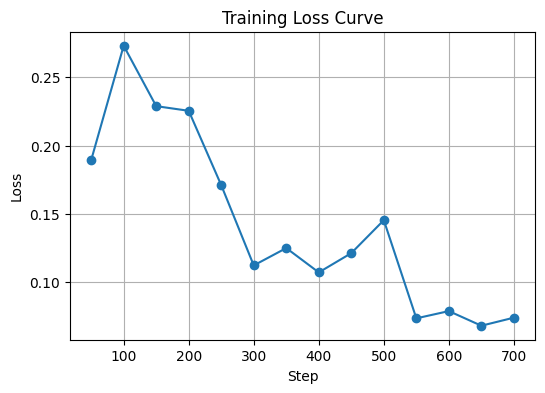

 Generating predictions on validation set


 Generated 983 predictions


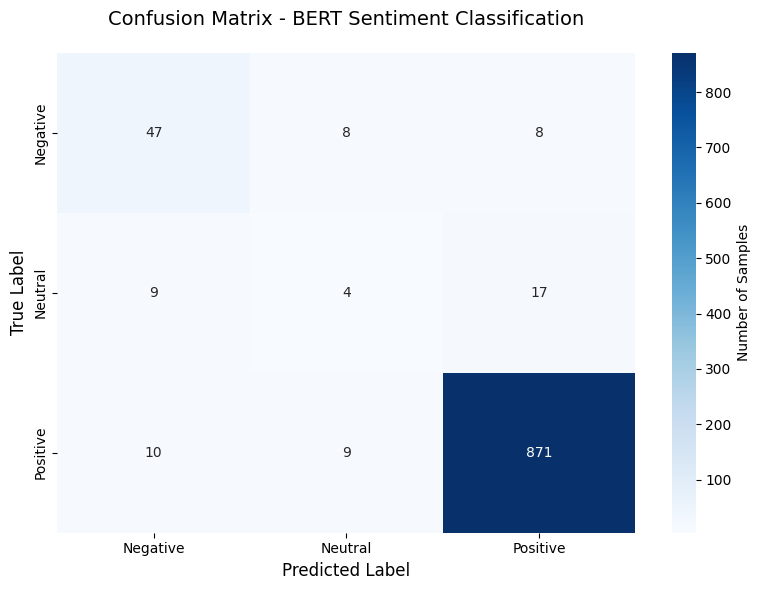

 Per-class accuracy:
   Negative: 0.746
   Neutral: 0.133
   Positive: 0.979
 Classification Report:
              precision  recall  f1-score   support
Negative         0.7121  0.7460    0.7287   63.0000
Neutral          0.1905  0.1333    0.1569   30.0000
Positive         0.9721  0.9787    0.9754  890.0000
accuracy         0.9379  0.9379    0.9379    0.9379
macro avg        0.6249  0.6193    0.6203  983.0000
weighted avg     0.9316  0.9379    0.9346  983.0000


In [32]:
# Generating predictions on validation dataset

def generate_predictions(trainer, val_dataset):
    """
     Making predictions on validation data.

     Returns predicted labels, true labels, and logits
     Get model predictions for detailed analysis

    """
    print(" Generating predictions on validation set")

    # Getting predictions from trained model
    predictions_output = trainer.predict(val_dataset)

    # Extracting components
    logits = predictions_output.predictions
    true_labels = predictions_output.label_ids

    # Converting logits to predicted classes
    predicted_labels = np.argmax(logits, axis=1)

    print(f" Generated {len(predicted_labels)} predictions")

    return predicted_labels, true_labels, logits

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    """
    Plotting confusion matrix heatmap.

    Shows model accuracy per class
    Helps identify misclassifications
    Uses class names for labeling

    """

    # Calculating confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Creating visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Number of Samples'}
    )

    plt.title("Confusion Matrix - BERT Sentiment Classification", fontsize=14, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Calculating and displaying accuracy per class
    print(" Per-class accuracy:")
    for i, class_name in enumerate(class_names):
        class_accuracy = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
        print(f"   {class_name}: {class_accuracy:.3f}")

def display_classification_report(true_labels, predicted_labels, class_names):
    """
    Showing classification report with precision, recall, and F1-score.

    Including per-class and overall metrics
    Useful for performance analysis and reporting
    """

    # Generating classification report as dictionary
    report_dict = classification_report(
        true_labels,
        predicted_labels,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # Converting to DataFrame for better formatting
    report_Amazonreview = pd.DataFrame(report_dict).transpose()

    # Rounding the numerical values to display clearly
    report_Amazonreview = report_Amazonreview.round(4)

    print(" Classification Report:")
    print(report_Amazonreview.to_string())


    return report_Amazonreview

def plot_training_history(trainer):
    """
      Plotting training progress and loss curves.

      Helps track model learning
      Detects overfitting or underfitting

    """

    # Extracting training history
    log_history = trainer.state.log_history

    # Separating training and evaluation logs
    train_logs = [entry for entry in log_history if 'loss' in entry and 'eval_loss' not in entry]
    eval_logs = [entry for entry in log_history if 'eval_loss' in entry]


 # Training loss curve
log_history = trainer.state.log_history
steps = [entry['step'] for entry in log_history if 'loss' in entry]
losses = [entry['loss'] for entry in log_history if 'loss' in entry]
plt.figure(figsize=(6,4))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



# Generating predictions
predicted_labels, true_labels, logits = generate_predictions(trainer, val_dataset)

# Defining class names for visualization
class_names = ["Negative", "Neutral", "Positive"]

# Creating visualizations and reports
plot_confusion_matrix(true_labels, predicted_labels, class_names)
classification_report_df = display_classification_report(true_labels, predicted_labels, class_names)
plot_training_history(trainer)

## Custom Sentiment Prediction with BERT

In [31]:
# predictions for new review text and Saving the model

def create_prediction_system(model, tokenizer, device=None):
    """
    Building a prediction system for new review text.

    Uses trained model and tokenizer
    Returns sentiment and confidence scores

    """
    # Auto-detecting device if not specified
    if device is None:
        device = next(model.parameters()).device

    # model in evaluation mode
    model.eval()

    # Defining label mapping
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

    def predict_sentiment(text, return_confidence=False):
        """
        Predicting sentiment for a single text input.

        Tokenizes input and runs predictions
        Returns label
        Uses same settings as during training

        """
        try:
            # Tokenizing the input text
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=256
            )

            # Moving inputs to the same device as the model
            inputs = {key: val.to(device) for key, val in inputs.items()}

            # Generating predictions without gradient computation
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            # Converting logits to probabilities
            probabilities = torch.nn.functional.softmax(logits, dim=-1)

            # Getting predicted class
            predicted_class = torch.argmax(logits, dim=-1).item()
            predicted_label = label_map[predicted_class]

            if return_confidence:
                # Returning prediction with confidence scores
                confidence_scores = {
                    label_map[i]: prob.item()
                    for i, prob in enumerate(probabilities[0])
                }
                return predicted_label, confidence_scores
            else:
                return predicted_label

        except Exception as e:
            print(f" Error in prediction: {str(e)}")
            return "Error" if not return_confidence else ("Error", {})

    return predict_sentiment

def demonstrate_predictions(predict_function, example_texts=None):
    """
    Displaying the prediction system with example texts.

    Tests model with sample reviews
    Useful for validation

    """
    print(" Demonstrating Custom Prediction System")


    # Example texts covering different sentiments and styles
    if example_texts is None:
        example_texts = [
            # Clearly negative examples
            "This product is terrible and I regret buying it. Complete waste of money!",
            "Worst purchase ever. Broke after one day. Horrible quality.",
            "I hate this product. It doesn't work at all and customer service is useless.",

            # Neutral examples
            "It's okay. Not the best, not the worst. Does what it's supposed to do.",
            "Average product. Nothing special but gets the job done.",
            "It works as expected. No major complaints but nothing exciting either.",

            # Clearly positive examples
            "Amazing product! Exceeded all my expectations. Highly recommend!",
            "Love this! Great quality and fast shipping. Will definitely buy again.",
            "Fantastic! This is exactly what I needed. Perfect in every way.",

            # Mixed/complex examples
            "The product is good but the delivery was delayed. Mixed feelings.",
            "Great features but a bit expensive. Still worth it though.",
            "Good quality but difficult to use. Instructions could be better."
        ]

    # Making predictions with confidence scores
    for i, text in enumerate(example_texts, 1):
        print(f"\n Example {i}:")
        print(f"Text: '{text}'")

        # Getting prediction with confidence
        prediction, confidence = predict_function(text, return_confidence=True)

        print(f" Prediction: {prediction}")
        print(f" Confidence scores:")
        for label, score in confidence.items():
            print(f"   {label}: {score:.3f}")

        # Adding visual indicator for confidence
        max_confidence = max(confidence.values())
        confidence_level = "High" if max_confidence > 0.8 else "Medium" if max_confidence > 0.6 else "Low"
        print(f" Confidence level: {confidence_level}")

def save_model_artifacts(trainer, tokenizer, output_dir="./final_model"):
    """
    Saving the trained model and tokenizer for future use.

    """

    # Creating output directory
    os.makedirs(output_dir, exist_ok=True)

    # Saving the model
    trainer.save_model(output_dir)


    # Saving the tokenizer
    tokenizer.save_pretrained(output_dir)


    # Saving training configuration
    training_config = {
        "model_name": "bert-base-uncased",
        "num_labels": 3,
        "max_length": 256,
        "num_epochs": 3,
        "batch_size": 16,
        "label_mapping": {0: "Negative", 1: "Neutral", 2: "Positive"}
    }

    import json
    with open(f"{output_dir}/training_config.json", "w") as f:
        json.dump(training_config, f, indent=2)


# Creating and demonstrating predictions
predict_sentiment = create_prediction_system(model, tokenizer)

# Demonstrating with example texts
demonstrate_predictions(predict_sentiment)

# Saving model artifacts
save_model_artifacts(trainer, tokenizer)


 Demonstrating Custom Prediction System

 Example 1:
Text: 'This product is terrible and I regret buying it. Complete waste of money!'
 Prediction: Negative
 Confidence scores:
   Negative: 0.972
   Neutral: 0.025
   Positive: 0.002
 Confidence level: High

 Example 2:
Text: 'Worst purchase ever. Broke after one day. Horrible quality.'
 Prediction: Negative
 Confidence scores:
   Negative: 0.955
   Neutral: 0.042
   Positive: 0.003
 Confidence level: High

 Example 3:
Text: 'I hate this product. It doesn't work at all and customer service is useless.'
 Prediction: Negative
 Confidence scores:
   Negative: 0.613
   Neutral: 0.343
   Positive: 0.044
 Confidence level: Medium

 Example 4:
Text: 'It's okay. Not the best, not the worst. Does what it's supposed to do.'
 Prediction: Positive
 Confidence scores:
   Negative: 0.001
   Neutral: 0.019
   Positive: 0.981
 Confidence level: High

 Example 5:
Text: 'Average product. Nothing special but gets the job done.'
 Prediction: Positive
 Conf